# French Employment by Town Data Analysis 

## 1. Import Libraries & Preprocess Data & Build Model Function

### 1.1 Import Libraries
<a href='section1.1'></a>

In [0]:
import numpy as np
import pandas as pd

from google.colab import files,drive
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point, Polygon
!pip install descartes
from descartes import PolygonPatch

!pip install pysal
!pip install mapclassify
import mapclassify
import pysal

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
files.upload()
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d etiennelq/french-employment-by-town

In [0]:
datasets = zipfile.ZipFile('french-employment-by-town.zip')
datasets.extractall('src')

### 1.2 Read File & Preprocessing
<a href='section1.2'></a>

In [0]:
firm_df= pd.read_csv('src/base_etablissement_par_tranche_effectif.csv')

firm_df = firm_df[firm_df["CODGEO"].apply(lambda x: str(x).isdigit())]
firm_df['CODGEO'] = firm_df['CODGEO'].astype(int)

In [0]:
town_df = pd.read_csv('src/name_geographic_information.csv')

# processing town_df, especially longitude column
town_df['longitude'] = town_df['longitude'].apply(lambda x:str(x).replace(',','.'))
town_df.drop(town_df[town_df['longitude']=='-'].index,inplace= True)
town_df.dropna(subset=['latitude','longitude'],inplace=True)
town_df["longitude"] = town_df["longitude"].astype(float)

In [0]:
salary_df = pd.read_csv("src/net_salary_per_town_categories.csv")

salary_df = salary_df[salary_df["CODGEO"].apply(lambda x: str(x).isdigit())]
salary_df['CODGEO'] = salary_df['CODGEO'].astype(int)

In [0]:
population_df = pd.read_csv('src/population.csv')

population_df = population_df[population_df["CODGEO"].apply(lambda x: str(x).isdigit())]
population_df['CODGEO'] = population_df['CODGEO'].astype(int)
population_df = population_df.drop(['LIBGEO',"NIVGEO"],axis=1)

In [0]:
department_df = gpd.read_file("src/departements.geojson")

### 1.3 Build Linear Regression Model Function
<a href='section1.3'></a>

In [0]:
def build_reg_model(testSize,df,need_output=False):
    X = df.iloc[:, :-1].values
    y = df.iloc[:,-1].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 0)
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    coefficients = {df.columns[x]:reg.coef_[x] for x in range(len(df.columns)-1)}
    if need_output:
        return coefficients, reg.intercept_,r2_score(y_test, y_pred),mean_squared_error(y_test, y_pred),X_train, X_test, y_train, y_test,y_pred
    return coefficients,reg.intercept_, r2_score(y_test, y_pred),mean_squared_error(y_test, y_pred)

## 2. EDA on Salary Data
<a href='section2'></a>

In [87]:
salary_df.describe()

,CODGEO,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,SNHMFE14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
count,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,...,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000
mean,52531.824946,13.712551,23.711886,14.571843,10.566379,11.238712,12.042295,20.226376,13.274878,10.310456,...,11.501547,9.549501,13.502330,15.882671,9.162581,12.060329,13.175798,9.819405,14.493793,17.688154
std,25781.402402,2.562868,2.836451,1.487597,0.812953,1.224076,1.790723,2.327173,0.990423,0.748591,...,1.291991,0.997259,2.365774,3.591603,0.453437,1.827818,2.252915,1.538884,2.855326,4.536457
min,1004.000000,10.200000,16.000000,11.600000,8.700000,8.300000,9.300000,12.000000,10.600000,8.700000,...,8.900000,7.900000,9.700000,10.500000,7.500000,9.100000,9.500000,7.800000,9.600000,10.800000
25%,33036.500000,12.100000,21.900000,13.800000,10.000000,10.600000,10.900000,18.800000,12.600000,9.800000,...,10.800000,9.200000,12.000000,13.700000,8.900000,10.900000,11.700000,9.400000,12.700000,14.900000
50%,56132.000000,13.000000,23.200000,14.400000,10.400000,11.000000,11.500000,20.000000,13.100000,10.100000,...,11.300000,9.500000,12.900000,15.000000,9.100000,11.600000,12.600000,9.700000,13.800000,16.600000
75%,74088.000000,14.500000,24.900000,15.100000,10.900000,11.600000,12.700000,21.400000,13.800000,10.600000,...,11.900000,9.700000,14.300000,16.900000,9.400000,12.700000,14.000000,10.000000,15.500000,19.000000
max,97424.000000,43.300000,51.500000,54.600000,17.500000,46.300000,26.700000,35.500000,19.000000,16.100000,...,53.200000,60.600000,38.100000,56.900000,12.000000,26.600000,31.000000,93.300000,45.400000,68.600000


### 2.1 Salary trend across Ages, group by Genders
 <a id='section2.1'></a>

No handles with labels found to put in legend.


[Text(0, 0, '18-25'), Text(0, 0, '26-50'), Text(0, 0, '>50')]

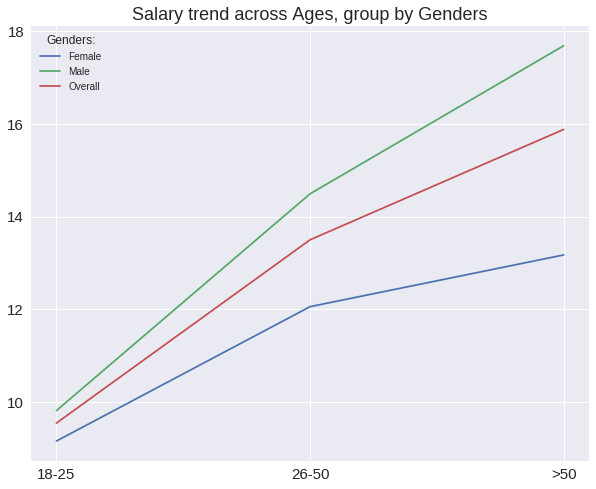

In [88]:
# salary acrosses gender & age groups
# [overall 18-25, o26-50, o>50, female 18-25, f26-50, f>50, male 18-25, m26-50, m>50]
avg_gender_age_salary = [salary_df[x].mean() for x in salary_df.columns[17:]]

index = ['18-25','26-50','>50']

gender_age_df = pd.DataFrame({
    'Overall':avg_gender_age_salary[:3],
    'Female':avg_gender_age_salary[3:6],
    'Male':avg_gender_age_salary[6:]},index=index)

fig,ax = plt.subplots(figsize=(10,8))
ax.set_title(label = "Salary trend across Ages, group by Genders",fontsize=18)
ax.legend(title='Genders:')
gender_age_plot = gender_age_df.plot.line(rot=0,fontsize = 15,ax=ax)
gender_age_plot.set_xticks(np.arange(len(index)))
gender_age_plot.set_xticklabels(index)

Findings:
*   We can see that Males always earn a higher salary than Females
*   The salary gap across genders increases with age
*  As females gets older, the increase in their salary is much lower compared to that of males, suggesting that females may tend not to move up the management laddler while males tends to.




### 2.2 Salary trend across Ages, group by Genders
 <a id='section2.2'></a>
 

No handles with labels found to put in legend.


[Text(0, 0, 'Worker'),
 Text(0, 0, 'Employee'),
 Text(0, 0, 'Middle Manager'),
 Text(0, 0, 'Executive')]

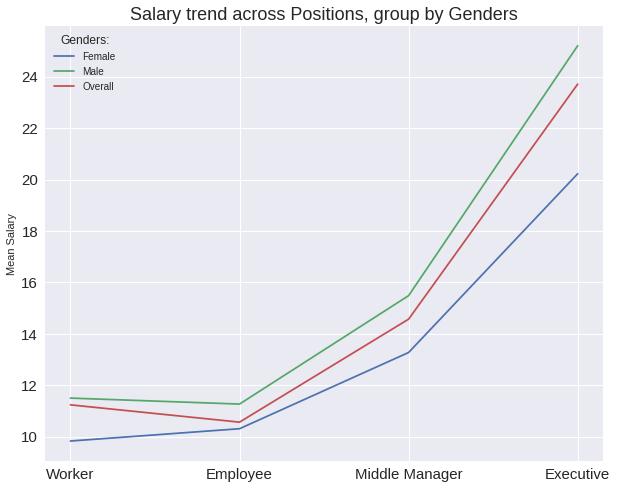

In [89]:
# salary trend acrosses positions, group by genders
overall = [salary_df[x].mean() for x in salary_df.columns[6:2:-1]]
female = [salary_df[x].mean() for x in salary_df.columns[11:7:-1]]
male = [salary_df[x].mean() for x in salary_df.columns[16:12:-1]]

index = ['Worker','Employee','Middle Manager','Executive']

gender_position_df = pd.DataFrame({
    'Overall':overall,
    'Female':female,
    'Male':male},index=index)
fig,ax = plt.subplots(figsize=(10,8))
ax.set_title(label = "Salary trend across Positions, group by Genders",fontsize=18)
ax.legend(title='Genders:')
plt.ylabel("Mean Salary")
gender_pos_plot = gender_position_df.plot.line(rot=0,ax=ax,fontsize=15)
gender_pos_plot.set_xticks(np.arange(len(index)))
gender_pos_plot.set_xticklabels(index)


Finding:

* The hypotheis is valid as the salary gap across genders increases from employees to middle managers to executives.
* The gradient of the graph / rate of increase is higher between higher managment positions than that between lower management positions.
* However, it is interesting to see that the salary gap across genders of workers is larger than that of employees



### 2.3 Salary Distribution across Genders
<a href='section2.3'></a>

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Propotion of population')

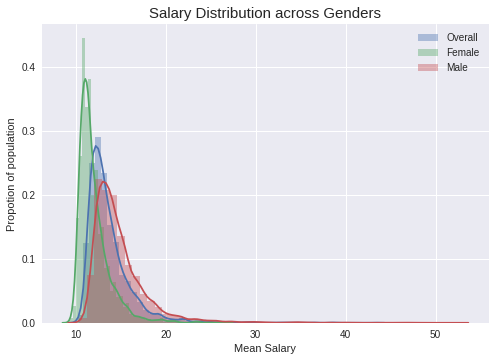

In [90]:
# plot distribution of overall mean salary, female mean salary and male mean salary

sns.set(color_codes=True)
avg_salary_df = salary_df[['SNHM14','SNHMF14','SNHMH14']]

for col in avg_salary_df.columns:
    sns.distplot(avg_salary_df[col])
    
plt.title("Salary Distribution across Genders",fontsize=15)
plt.legend(['Overall','Female',"Male"])
plt.xlabel("Mean Salary")
plt.ylabel('Propotion of population')

Finding:


*   The majority of females are earning below the overall mean salary rate while the majority of males are earning above it.
*   The salary differential between females and overall mean rate is larger than that between males and overall mean rate.
* There are very few males earning at the salary rate at which the majority of females are earning.



## 3. EDA on Firm Data
<a href='section3'></a>

In [91]:
firm_df.describe()

,CODGEO,REG,E14TST,E14TS0ND,E14TS1,E14TS6,E14TS10,E14TS20,E14TS50,E14TS100,E14TS200,E14TS500
count,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000
mean,46521.041051,48.973459,123.721704,83.713829,27.346659,5.237218,3.814956,2.308004,0.743317,0.334627,0.174197,0.048897
std,25513.105550,25.185044,2364.619186,1738.182920,434.069122,84.078419,61.250534,32.753222,9.929839,4.873106,2.797187,1.096414
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25269.000000,25.000000,8.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49159.000000,43.000000,19.000000,14.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67106.000000,73.000000,54.000000,39.000000,11.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,97617.000000,93.000000,427385.000000,316603.000000,76368.000000,14836.000000,10829.000000,5643.000000,1658.000000,812.000000,456.000000,180.000000


In [0]:
firm_size_mean_salary = pd.DataFrame(columns = salary_df.columns[2:])

In [0]:
# create a dataframe with all types of salaries for each firm size
firm_size_mean_salary['firm_size'] = firm_df.columns[6:]

for col in firm_size_mean_salary.columns[:-1]:
    firm_size_mean_salary[col] = [salary_df.loc[salary_df['CODGEO'].isin(firm_df.loc[firm_df[row]>0]['CODGEO'])][col].mean() for row in firm_size_mean_salary['firm_size']]

### 3.1 Salary trend across firm sizes, group by Genders
<a href='section3.1'></a>

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0, 0.5, 'Mean Salary')

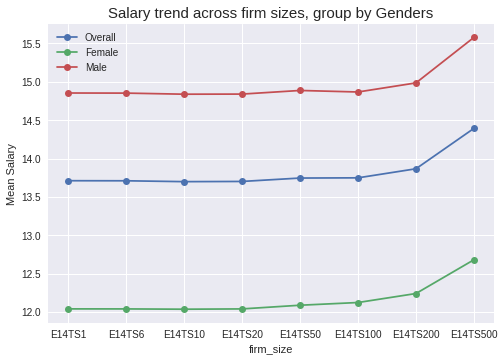

In [94]:
# firm_size vs mean salary across genders
mean_salary_gender_plot = firm_size_mean_salary.plot(x='firm_size', y=['SNHM14','SNHMF14','SNHMH14'], linestyle='-', marker='o')
# ensure the first label is shown
mean_salary_gender_plot.set_xticks(np.arange(len(firm_size_mean_salary['firm_size'])))
mean_salary_gender_plot.set_xticklabels(firm_size_mean_salary['firm_size'])

plt.title("Salary trend across firm sizes, group by Genders",fontsize=15)
plt.legend(['Overall','Female',"Male"])
plt.ylabel("Mean Salary")

Findings:

* Regardless of firm size, the salary differential between males and females are persistent
* The salary differential is a bit higher in larger firms.
* The mean salary for both males and females are higher in larger firms

### 3.2 Salary trend across firm sizes, group by Genders and Positions
<a href='section3.2'></a>




/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0, 0.5, 'Mean Salary')

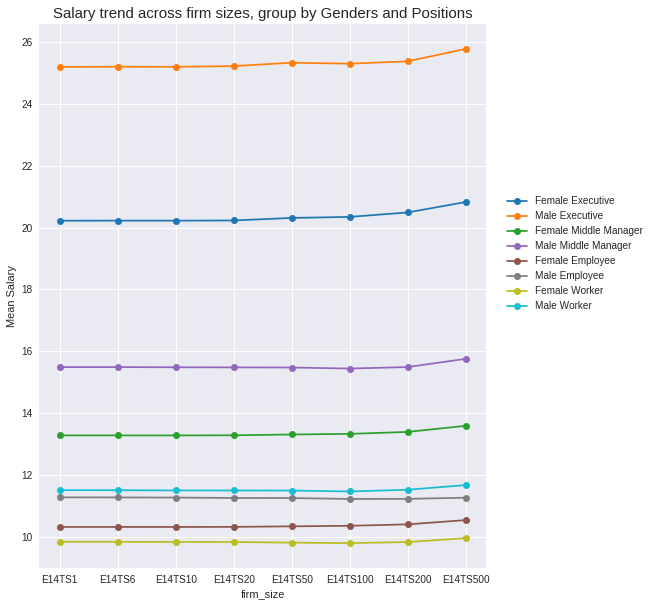

In [95]:
fig,ax =plt.subplots(figsize=(8,10))
# firm_size vs mean salary across genders
mean_salary_gp_plot = firm_size_mean_salary.plot(x='firm_size', y=['SNHMFC14','SNHMHC14','SNHMFP14','SNHMHP14','SNHMFE14','SNHMHE14','SNHMFO14','SNHMHO14'],
                                              linestyle='-', marker='o',colormap='tab10',ax=ax)
# ensure the first label is shown
mean_salary_gp_plot.set_xticks(np.arange(len(firm_size_mean_salary['firm_size'])))
mean_salary_gp_plot.set_xticklabels(firm_size_mean_salary['firm_size'])

ax.legend(labels = ['Female Executive','Male Executive','Female Middle Manager','Male Middle Manager','Female Employee','Male Employee'
           ,'Female Worker','Male Worker'] ,loc='upper center', bbox_to_anchor=(1.2, 0.7), shadow=True, ncol=1)

plt.title("Salary trend across firm sizes, group by Genders and Positions",fontsize=15)
plt.ylabel("Mean Salary")

Findings:

* Supports 2.2 where the salary gap between males and females is larger at higher positions.
* Male Workers have a higher salary in all firms than male employees, while female employees have a higher salary than female workers
* Male employees, despite having the lowest salary among all male positions, still earn a higher salary than both female employees and female workers.
> This reconciles with section 2.2, where mean Male worker salary is similar to mean Male employee salary, but mean Female worker salary is significantly lower than  Female employee salary.

>  > Since Male employee salary is higher than Female employee salary, Male worker salary is also higher than Female employee salary.

### 3.3 Salary trend across firm sizes, group by Ages
<a href='section3.3'></a>

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0, 0.5, 'Mean Salary')

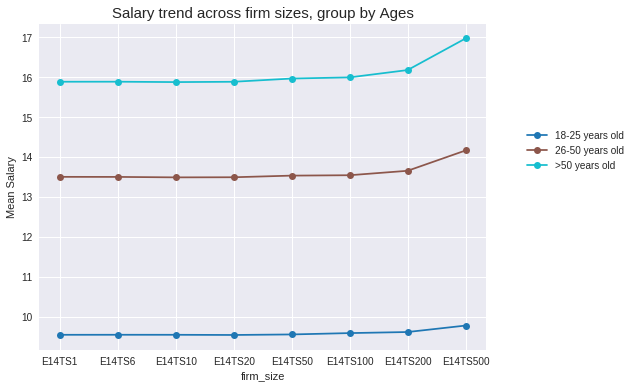

In [96]:
fig,ax =plt.subplots(figsize=(8,6))
# firm_size vs mean salary across genders
mean_salary_age_plot = firm_size_mean_salary.plot(x='firm_size', y=['SNHM1814','SNHM2614','SNHM5014'],
                                              linestyle='-', marker='o',colormap='tab10',ax=ax)
# ensure the first label is shown
mean_salary_age_plot.set_xticks(np.arange(len(firm_size_mean_salary['firm_size'])))
mean_salary_age_plot.set_xticklabels(firm_size_mean_salary['firm_size'])

ax.legend(labels = ['18-25 years old','26-50 years old','>50 years old'] ,loc='upper center', bbox_to_anchor=(1.2, 0.7), shadow=True, ncol=1)

plt.title("Salary trend across firm sizes, group by Ages",fontsize=15)
plt.ylabel("Mean Salary")

Finding:
* Higher age leads to higher salary, regardless of firm size
* At the same age, the larger the firm, the higher the salary

Overall finding:


*   There is a siginificant gender inequality in terms of earnings. The higher the positions in a company, especially in larger companies, the worse the inequality is (i.e. the larger the earning gap between males and females is).
* The wage gap across positions is also alarming,  and the gap is even larger for males than females
*   Such gender inequality is also observed with ages, potentially due to the high correlation between age and position levels.




### 3.4 Salary trend across firm sizes, group by Genders and Ages
<a href='section3.4'></a>

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0, 0.5, 'Mean Salary')

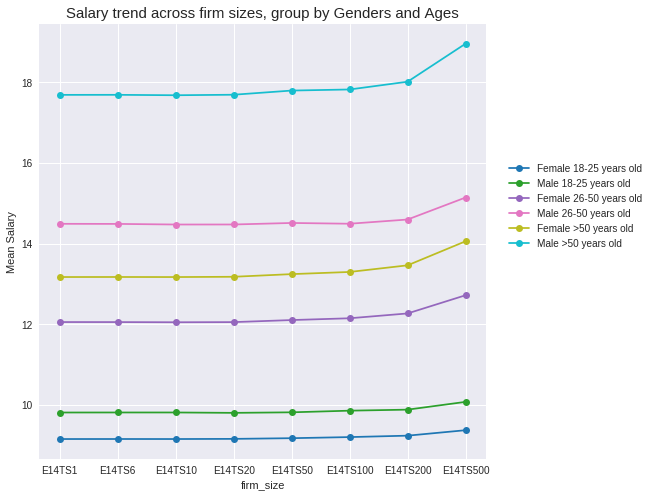

In [97]:
fig,ax =plt.subplots(figsize=(8,8))
# firm_size vs mean salary across genders
mean_salary_age_plot = firm_size_mean_salary.plot(x='firm_size', y=['SNHMF1814','SNHMH1814','SNHMF2614','SNHMH2614','SNHMF5014','SNHMH5014'],
                                              linestyle='-', marker='o',colormap='tab10',ax=ax)
# ensure the first label is shown
mean_salary_age_plot.set_xticks(np.arange(len(firm_size_mean_salary['firm_size'])))
    mean_salary_age_plot.set_xticklabels(firm_size_mean_salary['firm_size'])

ax.legend(labels = ['Female 18-25 years old','Male 18-25 years old','Female 26-50 years old','Male 26-50 years old',
                    'Female >50 years old','Male >50 years old'] ,loc='upper center', bbox_to_anchor=(1.2, 0.7), shadow=True, ncol=1)

plt.title("Salary trend across firm sizes, group by Genders and Ages",fontsize=15)
plt.ylabel("Mean Salary")

Findings:
* Higher age leads to higher salary, regardless of firm size and gender
* Male of 26 -50 years old earns a higher salary for both females of 26-50 and > 50 years old
* The gradient between E14TS200 and E14TS500, Male > 50 years old, is the largest, showing that males working in firms with more than 500 employees will gain the most amount of salary increase when they reach beyond 50 years old
    > This may be because firms with more than 500 employees have many higher management positions for males to move up, while in smaller firms, those may have reached the career ceiling.


## 4. Correlation Matrix and Linear Regression: Gender, Position vs Salary
<a href='section4'></a>

### 4.1 Correlation matrix: Gender, Position & Salary
<a href='section4.1'></a>

In [0]:
gender_pos_dict={}
gender_pos_dict["SNHMFC14"] = {"gender": 2, "position": 4}
gender_pos_dict["SNHMFP14"] = {"gender": 2, "position": 3}
gender_pos_dict["SNHMFE14"] = {"gender": 2, "position": 2}
gender_pos_dict["SNHMFO14"] = {"gender": 2, "position": 1}
gender_pos_dict["SNHMHC14"] = {"gender": 1, "position": 4}
gender_pos_dict["SNHMHP14"] = {"gender": 1, "position": 3}
gender_pos_dict["SNHMHE14"] = {"gender": 1, "position": 2}
gender_pos_dict["SNHMHO14"] = {"gender": 1, "position": 1}

# compile with gender_position
gp_compiled_data = []
for index, row in salary_df.iterrows():
    for key, value in gender_pos_dict.items(): 
        row_dict = {}
        row_dict["CODGEO"] = row["CODGEO"]
        row_dict["gender"] = value["gender"]
        row_dict["position"] = value["position"]
        row_dict["salary"] = row[key]
        gp_compiled_data.append(row_dict)

In [0]:
gp_compiled_df = pd.DataFrame(gp_compiled_data)

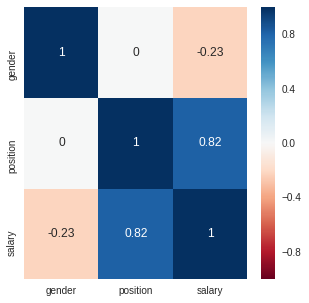

In [100]:
fig, ax = plt.subplots(figsize=(5,5))      
sns.heatmap(gp_compiled_df.drop(['CODGEO'],axis=1).corr(),linecolor='white',cmap='RdBu',annot=True,ax=ax)

Finding:
* Position is strongly and postively correlated to salary
* Gender is positively correlated to salary but the correlation is not very strong, showing that males are some what likely to have higher salaries.
Thus, there may be a possible interaction term of gender_position with salary, since we found that at the same position, males are earning more and the wage differential across genders increases with higher positions.


### 4.2 Regression Model of Gender, Position on Salary
<a href='section4.2'></a>

In [0]:
gp_compiled_df_reg =  gp_compiled_df.drop(['CODGEO'],axis=1)

In [0]:
result = build_reg_model(0.2,gp_compiled_df_reg ,True)

In [103]:
#coef
result[0]

{'gender': -2.4571436511687708, 'position': 3.9798006205782936}

In [104]:
#intercept
result[1]

8.382999612261315

In [105]:
print("R square value is:",result[2])
print("mean squared error is:",result[3])

R square value is: 0.7177324595662423
mean squared error is: 8.132154324696266


The R2 value is not very high, suggesting possible other relationships. 

Thus, I move on to try adding interaction terms

### 4.3 Correlation Matrix: Adding an Interaction Term: Gender_Position
<a href='section4.3'></a>

In [0]:
gp_compiled_df['gender_position']=gp_compiled_df['gender'] * gp_compiled_df['position']

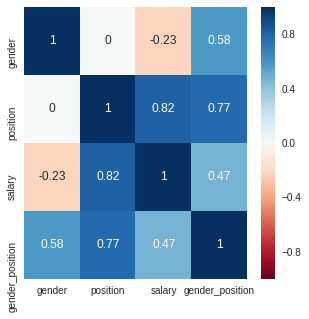

In [108]:
fig, ax = plt.subplots(figsize=(5,5))      
sns.heatmap(gp_compiled_df.drop(['CODGEO'],axis=1).corr(),linecolor='white',cmap='RdBu',annot=True,ax=ax)

As we can, gender_position is positively correlated to salary but not very strong. 

It means that gender and positions have interaction, the dominant impact on salary is still positions.

### 4.4 Regression Model of with Interaction Term
<a href='section4.4'></a>

In [0]:
gp_compiled_df_reg =  gp_compiled_df.drop(['CODGEO'],axis=1)
# re-arrange for train_test split
salary_col = gp_compiled_df_reg['salary']
gp_compiled_df_reg = gp_compiled_df_reg.drop(['salary'],axis=1)
gp_compiled_df_reg['salary'] = salary_col

In [0]:
result = build_reg_model(0.20, gp_compiled_df_reg,True)

In [111]:
#coef
result[0]

{'gender': 0.38282593637676693,
 'gender_position': -1.136127978366349,
 'position': 5.687358038980446}

In [112]:
#intercept
result[1]

4.111696490396101

In [113]:
print("R square value is:",result[2])
print("mean squared error is:",result[3])

R square value is: 0.729414865885953
mean squared error is: 7.795583102480268


Findings:

* It is intersting to see that after adding the interaction term, the coefficient for gender becomes positive from negative. However, as the coefficient for gender_position is negative with larger magnitude, it will overweigh the "positive" effect on gender

## 5. Correlation Matrix and Linear Regression: Gender, Age vs Salary
<a href='section5'></a>

### 5.1 Correlation Matrix: Gender, Age, Salary
<a href='section5.1'></a>

In [0]:
gender_age_dict={}
gender_age_dict["SNHMF1814"] = {"gender": 2, "age_group": 1}
gender_age_dict["SNHMF2614"] = {"gender": 2, "age_group": 2}
gender_age_dict["SNHMF5014"] = {"gender": 2, "age_group": 3}
gender_age_dict["SNHMH1814"] = {"gender": 1, "age_group": 1}
gender_age_dict["SNHMH2614"] = {"gender": 1, "age_group": 2}
gender_age_dict["SNHMH5014"] = {"gender": 1, "age_group": 3}

# compile with gender_position
ga_compiled_data = []
for index, row in salary_df.iterrows():
    for key, value in gender_age_dict.items(): 
        row_dict = {}
        row_dict["CODGEO"] = row["CODGEO"]
        row_dict["gender"] = value["gender"]
        row_dict["age_group"] = value["age_group"]
        row_dict["salary"] = row[key]
        ga_compiled_data.append(row_dict)

In [0]:
ga_compiled_df = pd.DataFrame(ga_compiled_data)    

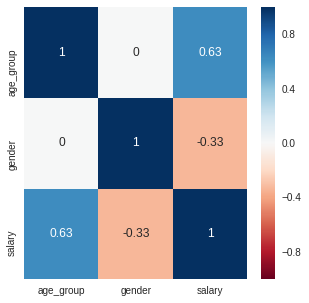

In [116]:
fig, ax = plt.subplots(figsize=(5,5))      
sns.heatmap(ga_compiled_df.drop(['CODGEO'],axis=1).corr(),linecolor='white',cmap='RdBu',annot=True,ax=ax)

Finding:

* Gender is again shown negatively correlated with salary
* Age is positively correlated with salary

  ### 5.2 Regression Model of Gender, Age on Salary 
  <a href='section5.2'></a>

In [0]:
ga_compiled_df_reg =  ga_compiled_df.drop(['CODGEO'],axis=1)

In [0]:
result = build_reg_model(0.2,ga_compiled_df_reg ,True)

In [119]:
#coef
result[0]

{'age_group': 2.9753899058493856, 'gender': -2.5519736222892213}

In [120]:
#intercept
result[1]

10.6180666583043

In [121]:
print("R square value is:",result[2])
print("mean squared error is:",result[3])

# very low R2 value, the model is not very useful

R square value is: 0.5036654168128494
mean squared error is: 7.152284348836362


## 6. Combined Regression Model
  <a href='section6'></a>


Combine age_group, MOCO, gender, firm_size, position together to predict salary

### 6.1 Linear Regression Model
<a href='section6.1'></a>


In [0]:
population_df_combined_reg = population_df.copy()

In [0]:
population_df_combined_reg = population_df_combined_reg.drop(population_df_combined_reg[population_df_combined_reg['AGEQ80_17']<20].index,axis=0)
population_df_combined_reg = population_df_combined_reg.drop(population_df_combined_reg[population_df_combined_reg['NB']==0].index,axis=0)

In [0]:
population_df_combined_reg['age_group'] =3 
population_df_combined_reg.loc[population_df_combined_reg['AGEQ80_17']==20,['age_group']] = 1
population_df_combined_reg.loc[(population_df_combined_reg.AGEQ80_17>20) & (population_df_combined_reg.AGEQ80_17<=50),['age_group']] = 2

In [0]:
# merge salary_df with population_df_combined_reg
# all_compiled_df = gp_compiled_df.drop(['gender_position'],axis=1)
all_compiled_df = gp_compiled_df.merge(population_df_combined_reg,how='left',left_on='CODGEO',right_on='CODGEO')

In [0]:
nb_col = all_compiled_df['NB']
all_compiled_df = all_compiled_df.drop(['NB'],axis=1)
all_compiled_df['NB'] = nb_col

In [0]:
all_compiled_df = all_compiled_df.drop(all_compiled_df[all_compiled_df['gender']!=all_compiled_df['SEXE']].index)
all_compiled_df = all_compiled_df.drop(["AGEQ80_17","SEXE"],axis = 1)

In [0]:
# merge rows with the same age_group
all_compiled_df = all_compiled_df.groupby(list(all_compiled_df.columns[:-1]),as_index=False).sum()

In [0]:
all_compiled_df[["MOCO","NB",'age_group']]=all_compiled_df[["MOCO","NB","age_group"]].astype(int)

In [0]:
# merge with firm_df
all_compiled_df= all_compiled_df.merge(firm_df,how='left',left_on='CODGEO',right_on='CODGEO')

In [0]:
# re-arrange for train_test split
salary_col = all_compiled_df['salary']
all_compiled_df = all_compiled_df.drop(['salary'],axis=1)
all_compiled_df['salary'] = salary_col

In [0]:
all_compiled_df = all_compiled_df.drop(['CODGEO',"LIBGEO","REG","DEP"],axis=1)

In [0]:
result = build_reg_model(0.2, all_compiled_df,True)

In [134]:
#coef
result[0]

{'E14TS0ND': 421567883.5117866,
 'E14TS1': 421567883.51017094,
 'E14TS10': 421567883.494154,
 'E14TS100': 421567883.5116072,
 'E14TS20': 421567883.5190457,
 'E14TS200': 421567883.5396995,
 'E14TS50': 421567883.525404,
 'E14TS500': 421567883.60000604,
 'E14TS6': 421567883.515451,
 'E14TST': -421567883.51138043,
 'MOCO': -0.000775258107222003,
 'NB': 1.3189981370231862e-05,
 'age_group': 0.005770508671395005,
 'gender': 0.3427521161058044,
 'gender_position': -1.1099913054046817,
 'position': 5.64838678918929}

In [135]:
#intercept
result[1]

4.209360441222939

In [136]:
print("R square value is:",result[2])
print("mean squared error is:",result[3])

R square value is: 0.7319834705258617
mean squared error is: 8.002910994334984


The R2 value is also not very high even with interaction terms.

Therefore, I moved on to use random forest regressor to see if a better model can be achieved.

### 6.2 Random Forest Regressor
<a href='section6.2'></a>

In [0]:
X = all_compiled_df.iloc[:, :-1].values
y = all_compiled_df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
rf_reg =RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10) .fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [140]:
r2,mse

(0.8848170328494626, 3.439336506512403)

The R2 value of the random forest regressor model is much better compared to a single linear regression model. 

## 7. Salary distrbution in different departments
  <a href='section7'></a>


In [0]:
salary_town_df = salary_df.merge(town_df,how='left',left_on='CODGEO',right_on="code_insee")

In [0]:
salary_town_df.dropna(subset=['latitude','longitude'],inplace=True)

In [0]:
# create a df of each dept salary
salary_dept_df = salary_town_df.groupby('numéro_département',as_index=False).mean()

In [0]:
# merge with department_df for plotting 
salary_dept_geo = gpd.GeoDataFrame(salary_dept_df.merge(department_df,how='left',left_on='numéro_département',right_on='code'))

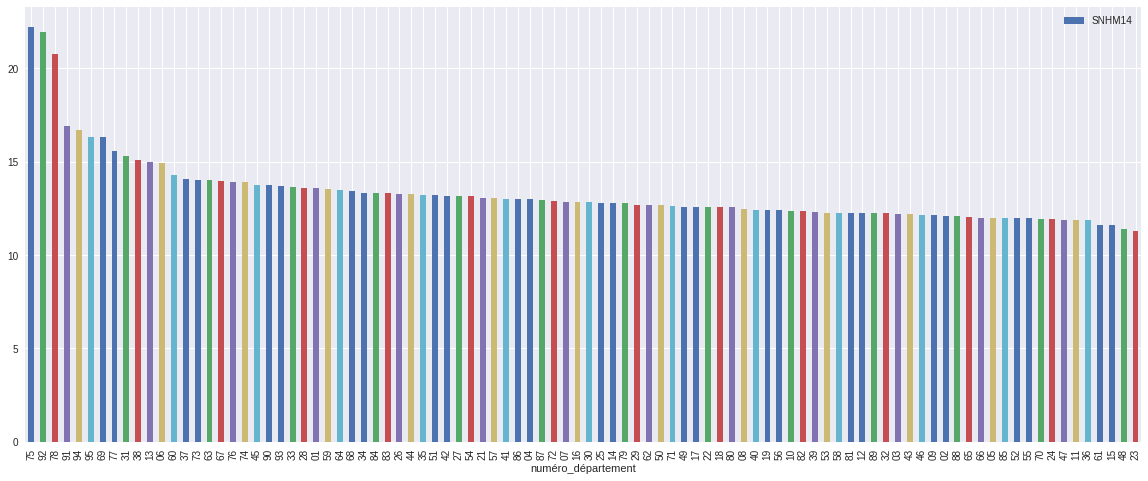

In [154]:
salary_dept_df.sort_values(by='SNHM14',axis=0,ascending=False).plot.bar(x='numéro_département',y='SNHM14',figsize=(20,8))

In [157]:
# find the top three departments with highest mean salary (way higher than the rest)
department_df.loc[department_df.code.isin(['75','92','78'])]

,code,nom,geometry
36,75,Paris,"POLYGON ((2.319887 48.90046, 2.329981 48.90116..."
37,78,Yvelines,"POLYGON ((2.200591 48.908679, 2.176518 48.9003..."
44,92,Hauts-de-Seine,"POLYGON ((2.290969 48.950966, 2.30198 48.95014..."


Finding:
* The three departments are found among the top departments in terms of GDP in France (based on Wikipedia)

* The mean salary for the rest of departments are not very far from each other, although some are higher while others are lower.

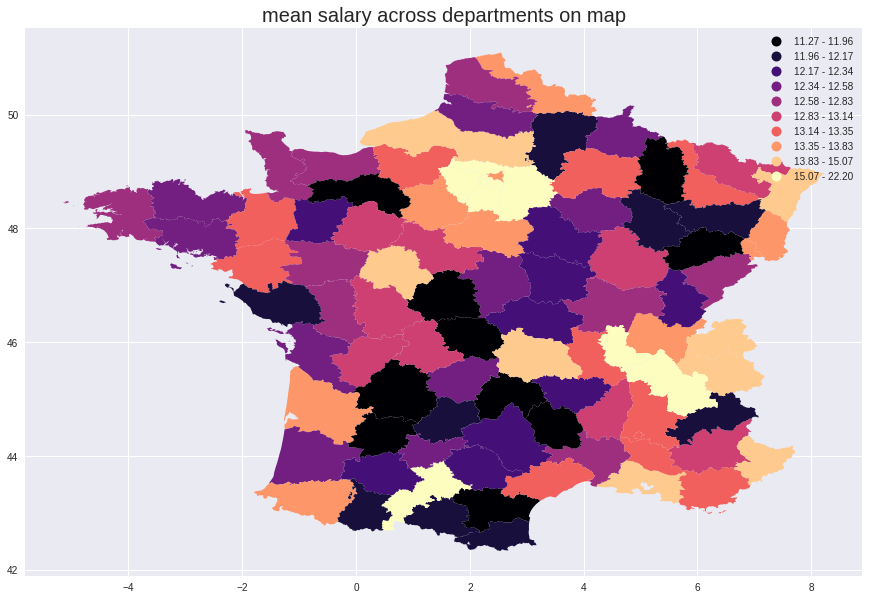

In [158]:
fig,ax = plt.subplots(figsize=(15,15))
ax.set_title(label='mean salary across departments on map',fontsize= 20)
salary_dept_plot = salary_dept_geo.plot(column='SNHM14',cmap='magma',legend=True,ax=ax,scheme='quantiles',k=10)

## 8. Male-Female ratio in different departments
  <a href='section8'></a>


In [0]:
population_gender_dist_df = population_df.copy()
population_gender_dist_df = population_gender_dist_df.groupby(['CODGEO',"SEXE"],as_index=False).sum()
population_gender_dist_df = population_gender_dist_df.drop(['MOCO',"AGEQ80_17"],axis=1)

In [0]:
population_gender_dist_pivot_table = population_gender_dist_df.pivot_table(index='CODGEO',values='NB',columns='SEXE')
population_gender_dist_pivot_table['MF_ratio'] = population_gender_dist_pivot_table[1] / population_gender_dist_pivot_table[2]
population_gender_dist_pivot_table['CODGEO'] = population_gender_dist_pivot_table.index

In [0]:
# remove inf and NaN
population_gender_dist_pivot_table.loc[population_gender_dist_pivot_table[2]==0,['MF_ratio']]=0

In [0]:
mf_town_df = population_gender_dist_pivot_table.merge(town_df,how='left',left_on='CODGEO',right_on="code_insee")

In [0]:
mf_town_df.dropna(subset=['latitude','longitude'],inplace=True)

In [0]:
mf_dept_df = mf_town_df.groupby(['numéro_département'],as_index=False).mean()

In [0]:
# merge with department_df for plotting 
mf_dept_geo = gpd.GeoDataFrame(mf_dept_df.merge(department_df,how='left',left_on='numéro_département',right_on='code'))

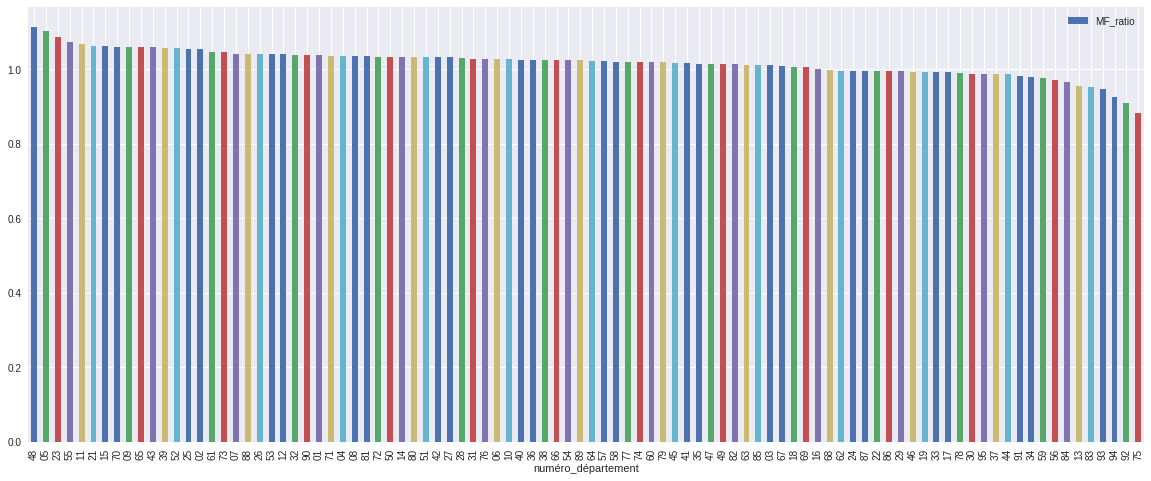

In [166]:
mf_dept_df.sort_values(by='MF_ratio',axis=0,ascending=False).plot.bar(x='numéro_département',y='MF_ratio',figsize=(20,8))

Finding:
* Most departments have more males than females

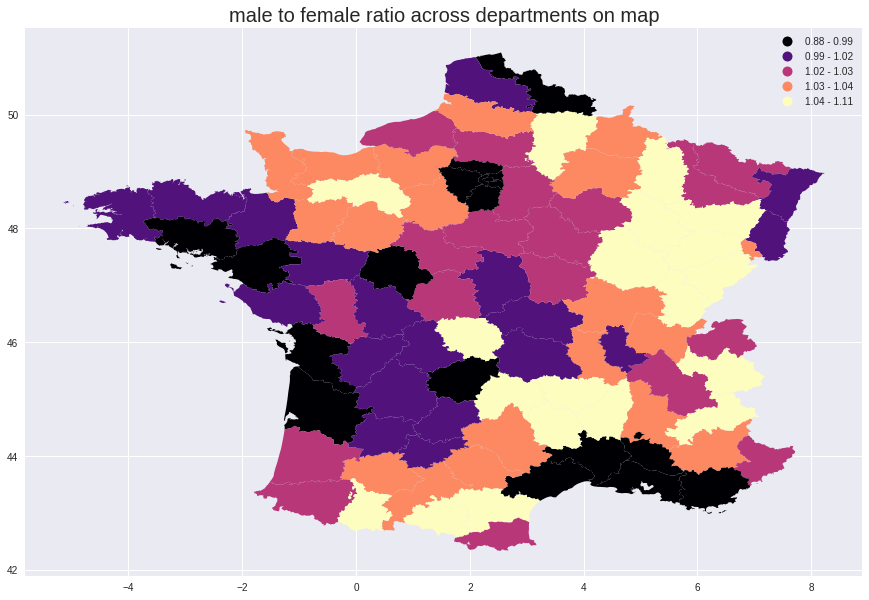

In [168]:
fig,ax = plt.subplots(figsize=(15,15)) 
ax.set_title(label='male to female ratio across departments on map',fontsize= 20)
mf_dept_plot = mf_dept_geo.plot(column='MF_ratio',cmap='magma',legend=True,ax=ax,scheme='quantiles')

## Population across ages in different departments
  <a href='section8'></a>

In [0]:
population_age_dist_df = population_df.copy()
population_age_dist_df = population_age_dist_df.groupby(['CODGEO',"AGEQ80_17"],as_index=False).sum()
population_age_dist_df = population_age_dist_df.drop(['MOCO',"SEXE"],axis=1)
population_age_dist_df = population_age_dist_df.drop(population_age_dist_df[population_age_dist_df.NB==0].index,axis=0)
population_age_dist_df = population_age_dist_df.dropna(subset=['NB'],axis=0)

In [0]:
# age group here is different from that in salary
# 1: 0-25 (before working) 2:26-60 (working before retirement) 3: 61-80 (retirement)

population_age_dist_df['age_group'] =2 
population_age_dist_df.loc[population_age_dist_df['AGEQ80_17']<=25,['age_group']] = 1
population_age_dist_df.loc[population_age_dist_df['AGEQ80_17']>60,['age_group']] = 3

In [0]:
population_age_dist_pivot_table = population_age_dist_df.pivot_table(index='CODGEO',values='NB',columns='age_group')
population_age_dist_pivot_table = population_age_dist_pivot_table.fillna(value=0).astype(int)
population_age_dist_pivot_table['CODGEO'] = population_age_dist_pivot_table.index

In [0]:
age_town_tf = population_age_dist_pivot_table.merge(town_df,how='left',left_on='CODGEO',right_on="code_insee")

In [0]:
age_town_tf.dropna(subset=['latitude','longitude'],inplace=True)

In [0]:
age_dept_df = age_town_tf.groupby(['numéro_département'],as_index=False).mean()

In [0]:
age_dept_df.drop(['code_région','CODGEO','numéro_circonscription','code_insee','éloignement'],axis=1,inplace=True)

In [176]:
age_dept_df.drop(['numéro_département','latitude','longitude'],axis=1).corr()

,1,2,3
1,1.000000,0.999990,0.999928
2,0.999990,1.000000,0.999955
3,0.999928,0.999955,1.000000


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


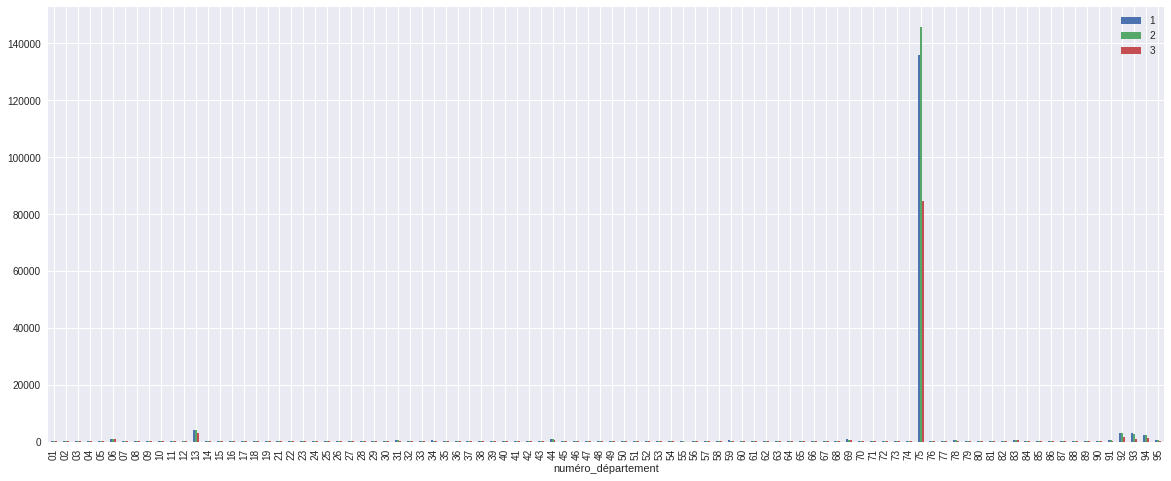

In [177]:
age_dept_df.plot.bar(x='numéro_département',y=[1,2,3],figsize=(20,8))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


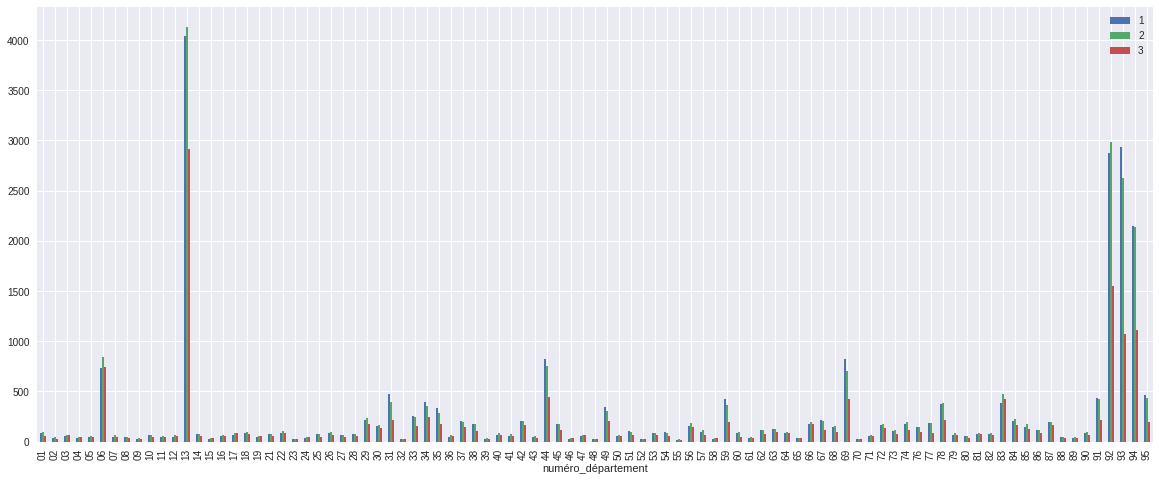

In [178]:
# dept 75 is Paris where the population is far far larger than any other department, causing the graph to be distored
age_dept_df.drop(age_dept_df.loc[age_dept_df.numéro_département=='75'].index,axis=0).plot.bar(x='numéro_département',y=[1,2,3],figsize=(20,8))

In [0]:
age_dept_df['total'] = age_dept_df[1] + age_dept_df[2] + age_dept_df[3]

In [0]:
age_dept_geo = gpd.GeoDataFrame(age_dept_df.merge(department_df,how='left',left_on='numéro_département',right_on='code'))

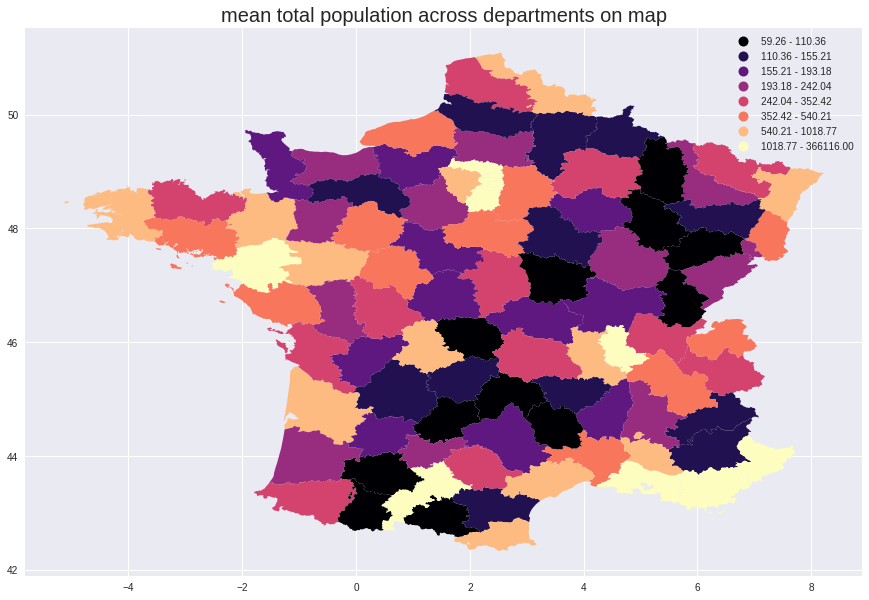

In [181]:
fig,ax = plt.subplots(figsize=(15,15)) 
ax.set_title(label='mean total population across departments on map',fontsize= 20)
age_dept_plot = age_dept_geo.plot(column='total',cmap='magma',legend=True,ax=ax,scheme='quantiles',k=8)